## Create binary UP and DOWN class from target variable ##

In [34]:
from zigzag import peak_valley_pivots, max_drawdown, compute_segment_returns, pivots_to_modes
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd

In [35]:
target_quote = 'EUR/GBP' # TARGET VARIABLE
# sample interval is of 30 seconds
df = pd.read_pickle('real_time_quotes.pandas')  
df = df.set_index(pd.DatetimeIndex(df['time']))
del df['time']
#df.resample?

In [36]:
# resample downsampling to 5T samples or 5*30s = 2:30
# 30S segundo, 1 T minuto
# ........................ 1T
#df = df.resample('30S', label='right', closed='right').pad()

In [37]:
df.head(4)

,EUR/USD,AUD/USD,GBP/USD,EUR/GBP,USD/CHF,USD/CAD,EUR/CHF
2016-05-31 09:21:20.981075,1.115340,0.72574,1.463800,0.76196,0.99019,1.303175,1.10441
2016-05-31 09:21:36.619171,1.115340,0.72575,1.463735,0.76200,0.99020,1.303185,1.10441
2016-05-31 09:21:42.940439,1.115380,0.72574,1.463730,0.76203,0.99018,1.303195,1.10444
2016-05-31 09:21:48.560504,1.115375,0.72574,1.463735,0.76200,0.99019,1.303195,1.10444


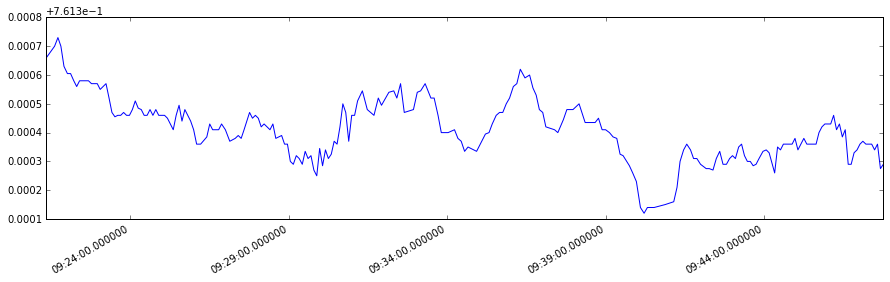

In [38]:
X = pd.DataFrame(df[target_quote]) # TARGET VARIABLE
f = plt.figure(figsize=(15,4))
X[target_quote].plot()

In [39]:
def create_binary_zig_zag_class(X, target_quote, pts_variation, plot=True):
    pivots = peak_valley_pivots(X[target_quote].values, pts_variation, -pts_variation)
    spivots = pd.Series(pivots, index=X.index)
    spivots = spivots[pivots != 0] # just the pivots point, when it changes to up or down
    X['pivots'] = pd.Series(pivots, index=X.index) # adding a collum
    
    if plot:
        f, axr = plt.subplots(2, sharex=True, figsize=(15,7))
        f.subplots_adjust(hspace=0)
        X[target_quote].plot(ax=axr[0])
        X.loc[spivots.index, target_quote].plot(ax=axr[0], style='.-')
        
    # make class of up (1) or down (0) trends from the zigzap indicator
    for i in range(len(spivots)-1):
        X.loc[ (X.index >= spivots.index[i]) & 
              (X.index < spivots.index[i+1]), 'du' ] = X['pivots'][spivots.index[i]]
    X.iat[-1, 2] = X.iat[-2, 2] # replicate in the end ups or downs
    X['du'] = -X['du']
    X.loc[:, 'du'].where( X['du'] > 0, 0, inplace=True) # where is bigger than zero dont change
    # 1 is up trend, 0 is down trend
    
    if plot:
        X['du'].plot(ax=axr[1])
        plt.ylim(-0.15, 1.15)
        plt.ylabel('up=1 down=0')
    
    del X['pivots']

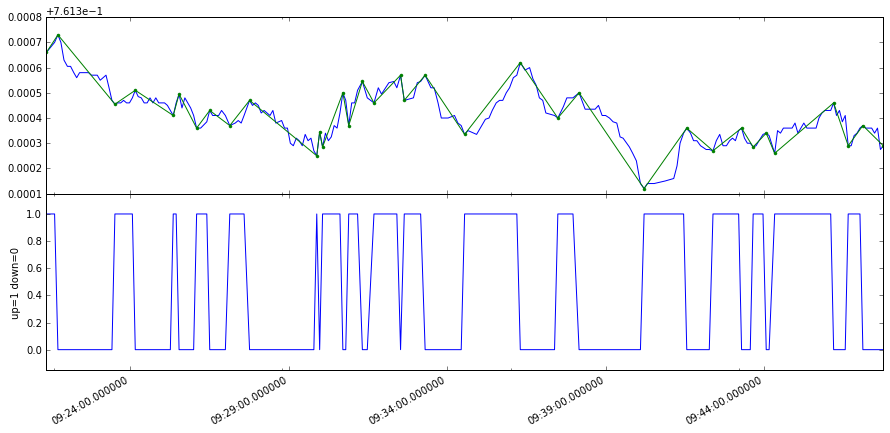

In [40]:
create_binary_zig_zag_class(X, target_quote, 0.00006, plot=True)

### For training of classification model ### 

Based on this guy [here](https://www.mql5.com/en/articles/1165) 

We will move 1 sample to the left (losing the right most).

This way we will be the target variable training our model with a **forecast of one sample**

The next **sample** will go **up** or **down**?



In [41]:
def make_shift_binary_class(X, shift, plot=True):

    if plot:
        f, axr = plt.subplots(2, sharex=True, figsize=(15,4))
        X['du'][-40:].plot(style='.-k', ax=axr[0])
        axr[0].set_ylim(-0.15, 1.15)
    
    X['dup'] = X['du'].shift(-shift) #shift = 1 # shift -1 sample to the left
    
    if plot:
        X['dup'][-40:].plot(style='.-k', ax=axr[1])
        axr[1].set_ylim(-0.15, 1.15)
    
    del X['du']

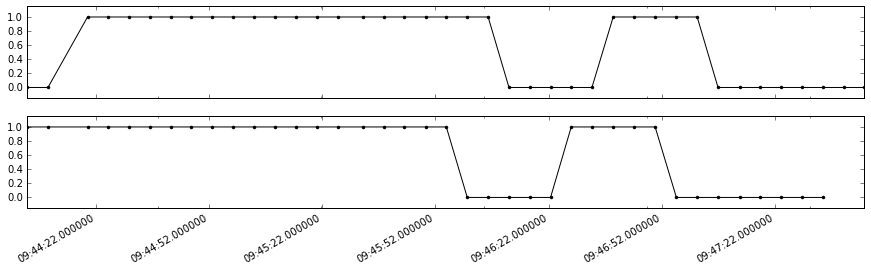

In [42]:
make_shift_binary_class(X, 2)

In [47]:
X.tail(15)

,EUR/GBP,dup
2016-05-31 09:46:27.967350,0.761685,1.0
2016-05-31 09:46:33.448308,0.761710,1.0
2016-05-31 09:46:39.084046,0.761590,1.0
2016-05-31 09:46:44.713203,0.761590,1.0
2016-05-31 09:46:50.196695,0.761630,1.0
2016-05-31 09:46:55.824652,0.761640,0.0
2016-05-31 09:47:01.328583,0.761660,0.0
2016-05-31 09:47:06.851371,0.761670,0.0
2016-05-31 09:47:12.549983,0.761660,0.0
2016-05-31 09:47:18.034530,0.761660,0.0


In [13]:
X[target_quote+' '+'dup'] = X['dup']

In [14]:
X = X['dup']

In [15]:
X.to_pickle('target_variable_dup.pandas')